#**Importing Data and Cleaning**

In [118]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


##Loading Data

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
csvs = glob.glob('/content/drive/MyDrive/EPL/E0*.csv')

In [121]:
# Keep only relevant columns
dfs = []
for file in csvs:
    try:
        print(f"📂 Reading: {file}")
        df = pd.read_csv(file, encoding='latin1',on_bad_lines='skip')
        dfs.append(df)
    except Exception as e:
        print(f"❌ Error reading {file}: {e}")

📂 Reading: /content/drive/MyDrive/EPL/E0(21).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(23).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(24).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(22).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(20).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(18).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(19).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(16).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(17).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(15).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(14).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(13).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(12).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(11).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(10).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(9).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(8).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(7).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(6).csv
📂 Reading: /content/drive/MyDrive/EPL/E0(5).csv
📂 Reading: /content/drive

###Cleaning

In [122]:
full_df = pd.concat(dfs, ignore_index=True)
full_df = full_df[['Date','HomeTeam','AwayTeam','FTR']]
full_df = full_df.sort_values('Date').reset_index(drop=True)
full_df.dropna(inplace=True)


###Encoding features

###Encoding Result

In [123]:
full_df['FTR'].unique()

array(['H', 'D', 'A'], dtype=object)

In [124]:
le_result = LabelEncoder()
full_df['FTR'] = le_result.fit_transform(full_df['FTR'])  # H = 2, D = 1, A = 0

###Encoding date

In [125]:
from datetime import datetime


In [126]:

def safe_parse_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    date_str = str(date_str).strip()

    # Try DD/MM/YYYY
    try:
        return datetime.strptime(date_str, '%d/%m/%Y')
    except:
        pass

    # Try DD/MM/YY with century fix
    try:
        parsed = datetime.strptime(date_str, '%d/%m/%y')
        if parsed.year > 2026:
            parsed = parsed.replace(year=parsed.year - 100)
        return parsed
    except:
        return pd.NaT




In [127]:
full_df['Date'] = full_df['Date'].astype(str).apply(safe_parse_date)
# Extract features again
full_df['Month'] = full_df['Date'].dt.month
full_df['Weekday'] = full_df['Date'].dt.weekday
full_df['Year'] = full_df['Date'].dt.year
full_df['is_weekend'] = full_df['Weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
full_df['is_first_half_season'] = full_df['Month'].apply(lambda x: 1 if x <= 12 and x >= 7 else 0)
full_df.drop(columns=['Date'], inplace=True)
full_df = full_df.sort_values(by=['Year','Month','Weekday']).reset_index(drop=True)
full_df.dropna(inplace=True)


In [128]:
full_df

,HomeTeam,AwayTeam,FTR,Month,Weekday,Year,is_weekend,is_first_half_season
0,Arsenal,Liverpool,2,8,0,2000,0,1
1,Arsenal,Liverpool,2,8,0,2000,0,1
2,Middlesbrough,Tottenham,1,8,1,2000,0,1
3,Ipswich,Man United,1,8,1,2000,0,1
4,Bradford,Chelsea,2,8,1,2000,0,1
...,...,...,...,...,...,...,...,...
9735,Chelsea,Ipswich,1,4,6,2025,1,0
9736,Leicester,Liverpool,0,4,6,2025,1,0
9737,Ipswich,Arsenal,0,4,6,2025,1,0
9738,Fulham,Chelsea,0,4,6,2025,1,0


#*Dataset Visualization*

###Home wins vs Away Wins

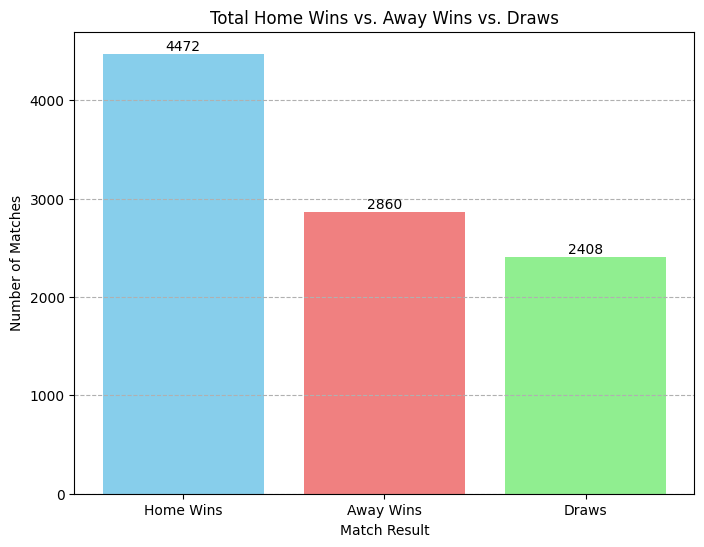

In [129]:

# Calculate total home wins, away wins, and draws
home_wins = len(full_df[full_df['FTR'] == 2])
away_wins = len(full_df[full_df['FTR'] == 0])
draws = len(full_df[full_df['FTR'] == 1])

# Create the bar graph
plt.figure(figsize=(8, 6))
plt.bar(['Home Wins', 'Away Wins', 'Draws'], [home_wins, away_wins, draws], color=['skyblue', 'lightcoral', 'lightgreen'])

# Customize the graph
plt.xlabel('Match Result')
plt.ylabel('Number of Matches')
plt.title('Total Home Wins vs. Away Wins vs. Draws')
plt.grid(axis='y', linestyle='--')  # Add a subtle grid

# Add value labels on top of each bar
for i, v in enumerate([home_wins, away_wins, draws]):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10) # Adjust 5 as needed

plt.show()


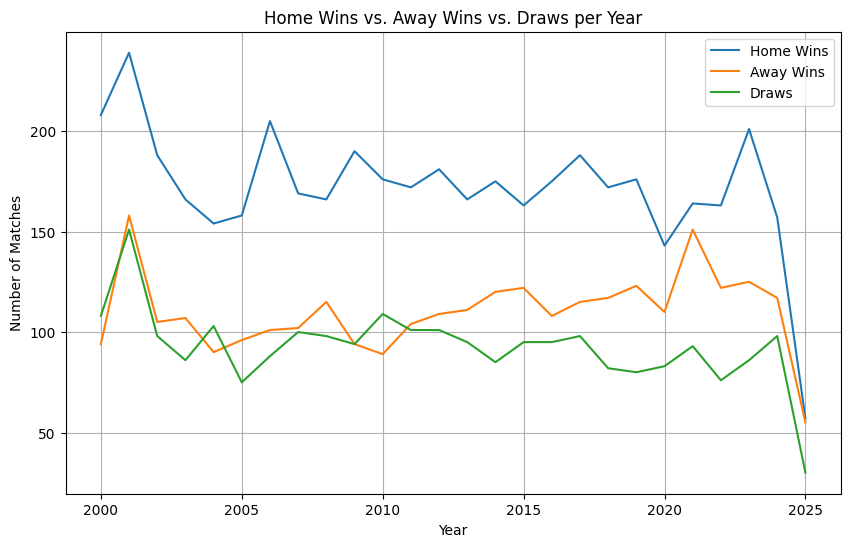

In [130]:


# Calculate draws per year
draws_by_year = full_df[full_df['FTR'] == 1].groupby('Year')['FTR'].count()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(home_wins_by_year.index, home_wins_by_year.values, label='Home Wins')
plt.plot(away_wins_by_year.index, away_wins_by_year.values, label='Away Wins')
plt.plot(draws_by_year.index, draws_by_year.values, label='Draws')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Matches')
plt.title('Home Wins vs. Away Wins vs. Draws per Year')
plt.legend()
plt.grid(True)
plt.show()


####Encoding Teams

In [131]:
import joblib
# Get full list of team names from raw data
team_names = pd.concat([full_df['HomeTeam'], full_df['AwayTeam']]).unique()

# Fit the encoder on strings
le_team_preditction = LabelEncoder()
le_team_preditction.fit(team_names)
joblib.dump(le_team_preditction, 'team_encoder.pkl')

['team_encoder.pkl']

In [63]:
print(le_team_preditction.classes_)

['Arsenal' 'Aston Villa' 'Birmingham' 'Blackburn' 'Blackpool' 'Bolton'
 'Bournemouth' 'Bradford' 'Brentford' 'Brighton' 'Burnley' 'Cardiff'
 'Charlton' 'Chelsea' 'Coventry' 'Crystal Palace' 'Derby' 'Everton'
 'Fulham' 'Huddersfield' 'Hull' 'Ipswich' 'Leeds' 'Leicester' 'Liverpool'
 'Luton' 'Man City' 'Man United' 'Middlesbrough' 'Newcastle' 'Norwich'
 "Nott'm Forest" 'Portsmouth' 'QPR' 'Reading' 'Sheffield United'
 'Southampton' 'Stoke' 'Sunderland' 'Swansea' 'Tottenham' 'Watford'
 'West Brom' 'West Ham' 'Wigan' 'Wolves']


In [132]:
full_df

,HomeTeam,AwayTeam,FTR,Month,Weekday,Year,is_weekend,is_first_half_season
0,Arsenal,Liverpool,2,8,0,2000,0,1
1,Arsenal,Liverpool,2,8,0,2000,0,1
2,Middlesbrough,Tottenham,1,8,1,2000,0,1
3,Ipswich,Man United,1,8,1,2000,0,1
4,Bradford,Chelsea,2,8,1,2000,0,1
...,...,...,...,...,...,...,...,...
9735,Chelsea,Ipswich,1,4,6,2025,1,0
9736,Leicester,Liverpool,0,4,6,2025,1,0
9737,Ipswich,Arsenal,0,4,6,2025,1,0
9738,Fulham,Chelsea,0,4,6,2025,1,0


In [133]:
le_team = LabelEncoder()
full_df['HomeTeam'] = le_team.fit_transform(full_df['HomeTeam'])
full_df['AwayTeam'] = le_team.transform(full_df['AwayTeam'])
num_teams = full_df['HomeTeam'].nunique()

In [134]:
full_df

,HomeTeam,AwayTeam,FTR,Month,Weekday,Year,is_weekend,is_first_half_season
0,0,24,2,8,0,2000,0,1
1,0,24,2,8,0,2000,0,1
2,28,40,1,8,1,2000,0,1
3,21,27,1,8,1,2000,0,1
4,7,13,2,8,1,2000,0,1
...,...,...,...,...,...,...,...,...
9735,13,21,1,4,6,2025,1,0
9736,23,24,0,4,6,2025,1,0
9737,21,0,0,4,6,2025,1,0
9738,18,13,0,4,6,2025,1,0


###Adding Last 5 Home/Away Wins

In [135]:
from collections import defaultdict

def add_last_5_home_wins(df):
    team_history = defaultdict(list)
    last_5_home_wins = []

    for _, row in df.iterrows():
        team = row['HomeTeam']
        prev_results = team_history[team][-5:]
        last_5_home_wins.append(prev_results.count('W'))

        # Update team history
        if row['FTR'] == 2:
            team_history[team].append('W')
        else:
            team_history[team].append('L')

    return last_5_home_wins


def add_last_5_away_wins(df):
    team_history = defaultdict(list)
    last_5_away_wins = []

    for _, row in df.iterrows():
        team = row['AwayTeam']
        prev_results = team_history[team][-5:]
        last_5_away_wins.append(prev_results.count('W'))

        # Update team history
        if row['FTR'] == 0:
            team_history[team].append('W')
        else:
            team_history[team].append('L')

    return last_5_away_wins


In [136]:
full_df['last_5_home_wins'] = add_last_5_home_wins(full_df)
full_df['last_5_away_wins'] = add_last_5_away_wins(full_df)
full_df.dropna(inplace=True)


##Final feature set


In [137]:
X = full_df[['HomeTeam', 'AwayTeam', 'Month', 'Weekday','Year','last_5_home_wins','last_5_away_wins','is_weekend', 'is_first_half_season']]
y = full_df['FTR']


#**Build & Train Neural Network**

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight


##Convert Data to PyTorch Tensors

In [139]:
# X is now a DataFrame
X_teams = X[['HomeTeam', 'AwayTeam']].values
X_other = X[['Month', 'Weekday', 'Year','last_5_home_wins','last_5_away_wins','is_weekend', 'is_first_half_season']].values

# Convert to tensors
X_teams_tensor = torch.tensor(X_teams, dtype=torch.long)
X_other_tensor = torch.tensor(X_other, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Train-test split
X_teams_train, X_teams_test, X_other_train, X_other_test, y_train, y_test = train_test_split(X_teams_tensor, X_other_tensor, y_tensor, test_size=0.2, random_state=42)

# Wrap into DataLoader
train_dataset = TensorDataset(X_teams_train, X_other_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [140]:
unique, counts = np.unique(y_train.numpy(), return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")


Class 0: 2290 samples
Class 1: 1909 samples
Class 2: 3593 samples


###Compute Balanced Class Weights

In [141]:
# Define class labels
classes = np.unique(y_train.numpy())

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.numpy())

# Convert to PyTorch tensor
class_weights = torch.tensor(weights, dtype=torch.float32)


##NN Model

In [142]:
class GoalSightWithEmbeddings(nn.Module):
    def __init__(self, num_teams, embedding_dim, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.home_embed = nn.Embedding(num_teams, embedding_dim)
        self.away_embed = nn.Embedding(num_teams, embedding_dim)

        self.fc = nn.Sequential(
             nn.Linear(embedding_dim * 2 + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_teams, x_other):
        home_team = self.home_embed(x_teams[:, 0])
        away_team = self.away_embed(x_teams[:, 1])
        x = torch.cat([home_team, away_team, x_other], dim=1)
        return self.fc(x)

model = GoalSightWithEmbeddings(
    num_teams=num_teams,
    embedding_dim=32,
    input_dim=7,         # Month, Weekday, Year, last_5_home_wins, last_5_away_wins, is_weekend, is_first_half_season
    hidden_dim=64,
    output_dim=3
)

##Set Up Training Components

In [143]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

##**Train the Model**

In [144]:
num_epochs = 75
epoch_losses = []
epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_count = 0

    for homeaway, other, labels in train_loader:
        outputs = model(homeaway, other)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batch_count += 1

    avg_loss = total_loss / batch_count
    epoch_losses.append(avg_loss)

    # Accuracy computed per epoch
    model.eval()
    with torch.no_grad():
        outputs = model(X_teams_test, X_other_test)
        _, predicted = torch.max(outputs, dim=1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}")

model.eval()
with torch.no_grad():
    outputs = model(X_teams_test, X_other_test)
    _, predicted = torch.max(outputs, dim=1)
    test_loss = criterion(outputs, y_test)
    f1 = f1_score(y_test, predicted, average='macro')

    print(f"\n📉 Final Test Loss: {test_loss.item():.4f}")
    print(f"🎯 Final F1 Score: {f1:.4f}")


Epoch 1/75, Loss: 10.6332, Accuracy: 45.12%
Epoch 2/75, Loss: 1.4299, Accuracy: 32.65%
Epoch 3/75, Loss: 1.1260, Accuracy: 39.58%
Epoch 4/75, Loss: 1.1102, Accuracy: 48.15%
Epoch 5/75, Loss: 1.0982, Accuracy: 50.51%
Epoch 6/75, Loss: 1.0760, Accuracy: 51.75%
Epoch 7/75, Loss: 1.0832, Accuracy: 39.48%
Epoch 8/75, Loss: 1.0618, Accuracy: 49.02%
Epoch 9/75, Loss: 1.0544, Accuracy: 51.80%
Epoch 10/75, Loss: 1.0487, Accuracy: 45.07%
Epoch 11/75, Loss: 1.0486, Accuracy: 47.84%
Epoch 12/75, Loss: 1.0466, Accuracy: 48.31%
Epoch 13/75, Loss: 1.0442, Accuracy: 49.23%
Epoch 14/75, Loss: 1.0383, Accuracy: 48.61%
Epoch 15/75, Loss: 1.0423, Accuracy: 49.64%
Epoch 16/75, Loss: 1.0438, Accuracy: 48.82%
Epoch 17/75, Loss: 1.0460, Accuracy: 46.25%
Epoch 18/75, Loss: 1.0403, Accuracy: 52.21%
Epoch 19/75, Loss: 1.0439, Accuracy: 50.00%
Epoch 20/75, Loss: 1.0425, Accuracy: 45.84%
Epoch 21/75, Loss: 1.0417, Accuracy: 45.33%
Epoch 22/75, Loss: 1.0432, Accuracy: 49.33%
Epoch 23/75, Loss: 1.0404, Accuracy: 49.

In [ ]:
torch.save(model.state_dict(), 'goalsight_model.pt')

In [ ]:
from google.colab import files
files.download('goalsight_model.pt')
files.download('team_encoder.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##*Model Performance Visualization*

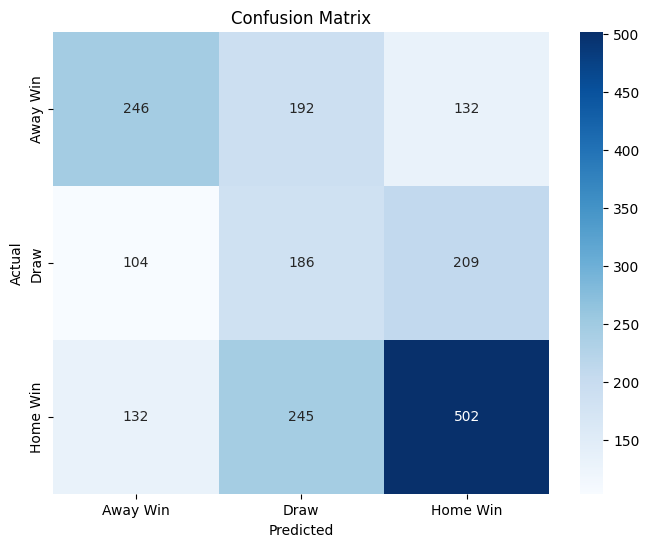

In [145]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


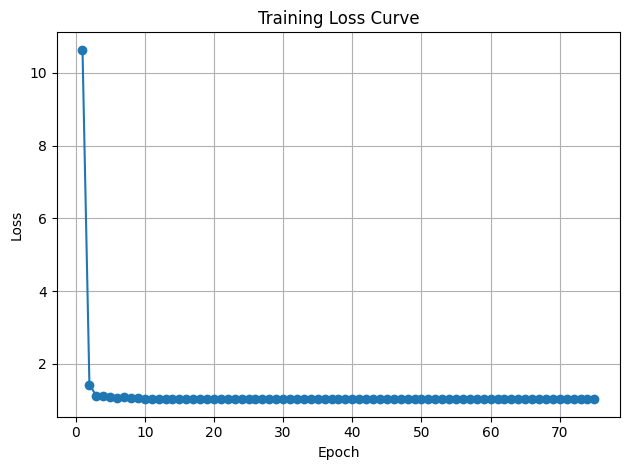

In [146]:

plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()



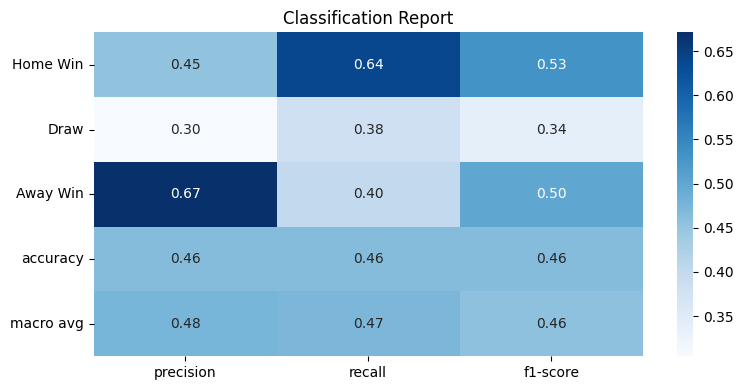

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert classification report to a dictionary and then to DataFrame
report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Drop support if you only want precision/recall/f1
df_report = df_report.drop(columns=['support'])

# Plot as heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1], annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report")
plt.tight_layout()
plt.show()


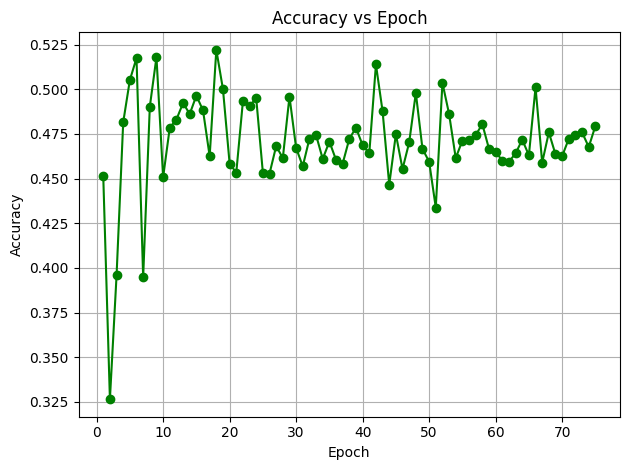

In [148]:

plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', color='green')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


#**Test Run**

In [ ]:
# Example team names
home_team = 'Chelsea'
away_team = 'Ipswich'

# Example match info (e.g., Oct 6, 2024 — a Sunday)
match_date = pd.to_datetime('2025-04-13')
month = match_date.month
weekday = match_date.weekday()
year = match_date.year

# You need the label encoder from training
le_team = joblib.load('team_encoder.pkl')
home_encoded = le_team.transform([home_team])[0]
away_encoded = le_team.transform([away_team])[0]

# Simulated values — you should compute these from your data!
last_5_home_wins = 3
last_5_away_wins = 1
is_weekend = 1 if weekday in [5, 6] else 0
is_first_half = 1 if 7 <= month <= 12 else 0



In [ ]:

X_team_input = torch.tensor([[home_encoded, away_encoded]], dtype=torch.long)
X_other_input = torch.tensor([[month, weekday, year,
                               last_5_home_wins, last_5_away_wins,
                               is_weekend, is_first_half]], dtype=torch.float32)


In [ ]:
model.eval()
with torch.no_grad():
    output = model(X_team_input, X_other_input)
    probabilities = torch.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities).item()


In [ ]:
outcomes = ['Away Win', 'Draw', 'Home Win']
print("Prediction:", outcomes[predicted_class])
print("Probabilities:", probabilities.numpy())


Prediction: Home Win
Probabilities: [[0.2044193  0.30260384 0.49297687]]
